# Deep Q-Networks (DQN): Deep RL From Scratch

**Goal**: Understand how neural networks replace Q-tables, and the tricks that make it work.

## The Problem with Tabular Methods
- FrozenLake: 16 states → Q-table is 16×4 = 64 values. Easy.
- CartPole: 4 continuous values → infinite states. Can't use a table.
- Atari: 210×160×3 pixel images → ~10^70000 possible states. Impossible.

**Solution**: Approximate Q(s, a) with a neural network: Q(s, a; θ)

## DQN's Three Key Innovations
1. **Neural network** Q-function approximation
2. **Experience replay** → break correlations between consecutive samples
3. **Target network** → stabilize the moving target problem

In [1]:
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque

from rl_lab.agents.dqn import DQNAgent, ReplayBuffer
from rl_lab.utils.common import get_device

device = get_device()
print(f"Using device: {device}")

Using device: mps


---
## 1. Why Naive Q-Learning + Neural Nets Fails

If you just replace the Q-table with a neural net and train naively:

### Problem 1: Correlated Samples
Consecutive transitions (s₁→s₂→s₃) are highly correlated. Neural nets assume i.i.d. data.
Training on correlated data → catastrophic forgetting, oscillation.

**Fix**: Experience Replay → sample random mini-batches from a buffer

### Problem 2: Moving Target
We update Q(s,a) toward `r + γ max Q(s', a')`, but `max Q(s', a')` changes every update!
It's like chasing a moving target → instability, divergence.

**Fix**: Target Network → use a frozen copy for computing targets, update periodically

---
## 2. Experience Replay Visualized

In [2]:
# Demonstrate experience replay
env = gym.make('CartPole-v1')
buffer = ReplayBuffer(capacity=10000)

# Fill buffer with some experience
state, _ = env.reset()
for _ in range(500):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    buffer.push(state, action, reward, next_state, terminated or truncated)
    state = next_state
    if terminated or truncated:
        state, _ = env.reset()

print(f"Buffer size: {len(buffer)}")

# Sample a batch
states, actions, rewards, next_states, dones = buffer.sample(32)
print(f"Batch shapes: states={states.shape}, actions={actions.shape}")
print(f"\nSample state: {states[0].numpy()}")
print(f"Sample action: {actions[0].item()}")
print(f"Sample reward: {rewards[0].item()}")

Buffer size: 500
Batch shapes: states=torch.Size([32, 4]), actions=torch.Size([32])

Sample state: [-0.01838609 -0.34706974  0.08342501  0.7177738 ]
Sample action: 1
Sample reward: 1.0


---
## 3. Train DQN on CartPole

In [3]:
def train_dqn(agent, env, n_episodes=500, max_steps=500):
    """
    Train DQN agent and track metrics.
    
    Args:
        agent: DQNAgent instance
        env: Gymnasium environment
        n_episodes: Number of training episodes
        max_steps: Max steps per episode
    
    Returns:
        Dict with training history
    """
    rewards_history = []
    losses = []
    epsilons = []
    
    for ep in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        ep_losses = []
        
        for step in range(max_steps):
            action = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            metrics = agent.update(state, action, reward, next_state, done)
            if 'loss' in metrics:
                ep_losses.append(metrics['loss'])
            
            total_reward += reward
            state = next_state
            if done:
                break
        
        agent.decay_epsilon()
        rewards_history.append(total_reward)
        losses.append(np.mean(ep_losses) if ep_losses else 0)
        epsilons.append(agent.epsilon)
        
        if (ep + 1) % 50 == 0:
            avg = np.mean(rewards_history[-50:])
            print(f"Episode {ep+1}: avg reward = {avg:.1f}, ε = {agent.epsilon:.3f}")
    
    return {'rewards': rewards_history, 'losses': losses, 'epsilons': epsilons}

In [4]:
# Create and train DQN agent
env = gym.make('CartPole-v1')

agent = DQNAgent(
    obs_dim=env.observation_space.shape[0],
    n_actions=env.action_space.n,
    hidden_dim=128,
    lr=1e-3,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    buffer_size=50000,
    batch_size=64,
    target_update_freq=100,
    device=device,
    seed=42,
)

results = train_dqn(agent, env, n_episodes=500)

Episode 50: avg reward = 24.0, ε = 0.778
Episode 100: avg reward = 38.4, ε = 0.606
Episode 150: avg reward = 23.9, ε = 0.471
Episode 200: avg reward = 59.6, ε = 0.367
Episode 250: avg reward = 41.7, ε = 0.286
Episode 300: avg reward = 61.8, ε = 0.222
Episode 350: avg reward = 201.9, ε = 0.173
Episode 400: avg reward = 113.0, ε = 0.135
Episode 450: avg reward = 209.7, ε = 0.105
Episode 500: avg reward = 128.1, ε = 0.082


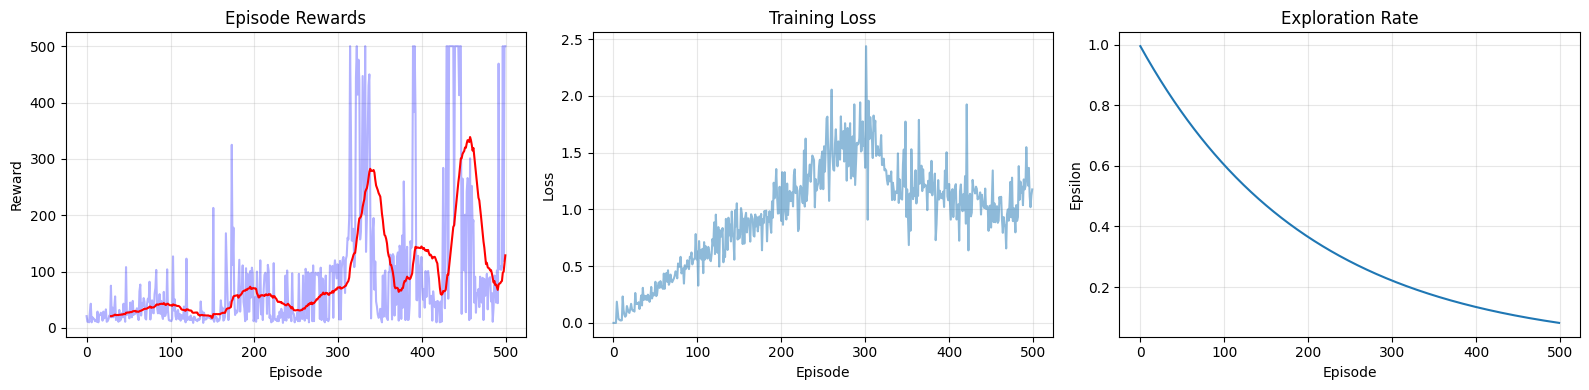

In [5]:
# Plot training metrics
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Rewards
ax = axes[0]
ax.plot(results['rewards'], alpha=0.3, color='blue')
window = 30
rolling = np.convolve(results['rewards'], np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(results['rewards'])), rolling, color='red')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Episode Rewards')
ax.grid(True, alpha=0.3)

# Loss
ax = axes[1]
ax.plot(results['losses'], alpha=0.5)
ax.set_xlabel('Episode')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.grid(True, alpha=0.3)

# Epsilon
ax = axes[2]
ax.plot(results['epsilons'])
ax.set_xlabel('Episode')
ax.set_ylabel('Epsilon')
ax.set_title('Exploration Rate')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. Ablation: Why Each Component Matters

In [6]:
# Train with different target update frequencies to see the effect
ablation_results = {}

for freq_label, freq in [("No target net (freq=1)", 1), ("freq=100", 100), ("freq=1000", 1000)]:
    print(f"\nTraining with target update {freq_label}...")
    env = gym.make('CartPole-v1')
    abl_agent = DQNAgent(
        obs_dim=4, n_actions=2, hidden_dim=128,
        lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
        buffer_size=50000, batch_size=64,
        target_update_freq=freq, device=device, seed=42,
    )
    ablation_results[freq_label] = train_dqn(abl_agent, env, n_episodes=300)


Training with target update No target net (freq=1)...
Episode 50: avg reward = 24.1, ε = 0.778
Episode 100: avg reward = 18.1, ε = 0.606
Episode 150: avg reward = 15.1, ε = 0.471
Episode 200: avg reward = 13.0, ε = 0.367
Episode 250: avg reward = 11.3, ε = 0.286
Episode 300: avg reward = 10.8, ε = 0.222

Training with target update freq=100...
Episode 50: avg reward = 21.7, ε = 0.778
Episode 100: avg reward = 45.6, ε = 0.606
Episode 150: avg reward = 34.7, ε = 0.471
Episode 200: avg reward = 70.3, ε = 0.367
Episode 250: avg reward = 78.7, ε = 0.286
Episode 300: avg reward = 29.5, ε = 0.222

Training with target update freq=1000...
Episode 50: avg reward = 25.5, ε = 0.778
Episode 100: avg reward = 24.1, ε = 0.606
Episode 150: avg reward = 27.3, ε = 0.471
Episode 200: avg reward = 37.7, ε = 0.367
Episode 250: avg reward = 79.0, ε = 0.286
Episode 300: avg reward = 76.3, ε = 0.222


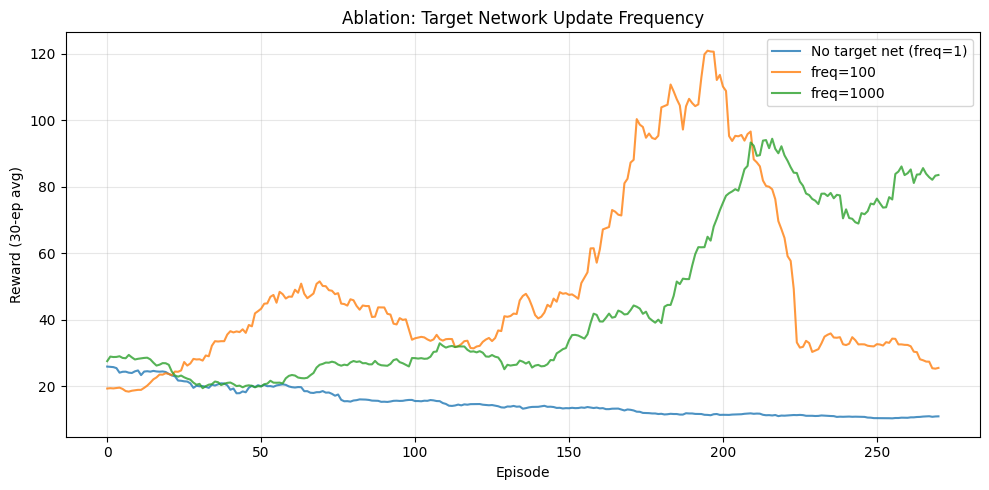

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
window = 30
for label, data in ablation_results.items():
    rolling = np.convolve(data['rewards'], np.ones(window)/window, mode='valid')
    ax.plot(rolling, label=label, alpha=0.8)

ax.set_xlabel('Episode')
ax.set_ylabel(f'Reward ({window}-ep avg)')
ax.set_title('Ablation: Target Network Update Frequency')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 5. DQN on LunarLander (Harder Environment)

In [8]:
# LunarLander: 8D observation, 4 discrete actions
ll_env = gym.make('LunarLander-v3')
print(f"Obs space: {ll_env.observation_space}")
print(f"Action space: {ll_env.action_space} (0=noop, 1=left, 2=main, 3=right)")

ll_agent = DQNAgent(
    obs_dim=8, n_actions=4, hidden_dim=256,
    lr=5e-4, gamma=0.99,
    epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.998,
    buffer_size=100000, batch_size=128,
    target_update_freq=200,
    device=device, seed=42,
)

ll_results = train_dqn(ll_agent, ll_env, n_episodes=800)

/Users/karthik/Projects/Personal/Reinforcement-Learning/.venv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Obs space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4) (0=noop, 1=left, 2=main, 3=right)
Episode 50: avg reward = -158.8, ε = 0.905
Episode 100: avg reward = -107.9, ε = 0.819
Episode 150: avg reward = -80.9, ε = 0.741
Episode 200: avg reward = -73.0, ε = 0.670
Episode 250: avg reward = -59.4, ε = 0.606
Episode 300: avg reward = -31.1, ε = 0.548
Episode 350: avg reward = -20.8, ε = 0.496
Episode 400: avg reward = -10.7, ε = 0.449
Episode 450: avg reward = 7.2, ε = 0.406
Episode 500: avg reward = 33.5, ε = 0.368
Episode 550: avg reward = 32.4, ε = 0.333
Episode 600: avg reward = 47.8, ε = 0.301
Episode 650: avg reward = 36.4, ε = 0.272
Episode 700: avg reward = 41.0, ε = 0.246
Episode 750: avg reward = 49.6, ε = 0.223
Episode 800: avg reward = 98.5, ε = 0.202


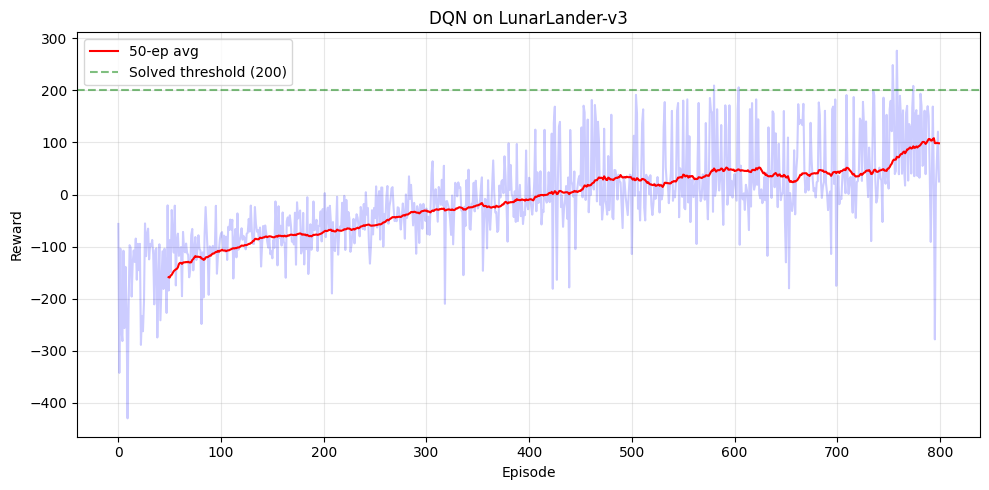

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ll_results['rewards'], alpha=0.2, color='blue')
window = 50
rolling = np.convolve(ll_results['rewards'], np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(ll_results['rewards'])), rolling, color='red', label=f'{window}-ep avg')
ax.axhline(y=200, color='green', linestyle='--', alpha=0.5, label='Solved threshold (200)')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('DQN on LunarLander-v3')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 6. Key Takeaways

### DQN = Q-Learning + 3 Tricks
1. **Neural network**: Generalizes across states (no table needed)
2. **Experience replay**: Random sampling → i.i.d. training data
3. **Target network**: Stable targets → stable training

### Limitations of DQN
- Only works for **discrete** actions (argmax over Q-values)
- Tends to **overestimate** Q-values (fixable with Double DQN)
- Exploration is basic (ε-greedy)
- No obvious way to represent stochastic policies

### DQN Extensions (for reference)
| Extension | Key Idea |
|-----------|----------|
| Double DQN | Separate action selection from evaluation |
| Dueling DQN | Separate V(s) and A(s,a) streams |
| Prioritized Replay | Sample important transitions more often |
| Rainbow | Combine all the above |

### DQN vs Policy Gradients
| DQN | Policy Gradients |
|-----|------------------|
| Discrete actions only | Continuous or discrete |
| More sample efficient | Less sample efficient |
| Off-policy (replay buffer) | Usually on-policy |
| No stochastic policies | Natural stochastic policies |

**Next**: PPO — the best of both worlds, and the backbone of RLHF